In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
random.seed(7)
from collections import Counter

In [2]:
starting_line = {(3, 0), (4, 0), (5, 0), (6, 0)}
finishing_line = {(9, 3), (9, 4), (9, 5), (9, 6)}
track = {
    (3,1), (4,1), (5,1), (6,1),
    (3,2), (4,2), (5,2), (6,2),
    (3,3), (4,3), (5,3), (6,3), (7,3), (8,3),
    (3,4), (4,4), (5,4), (6,4), (7,4), (8,4),
    (3,5), (4,5), (5,5), (6,5), (7,5), (8,5),
    (3,6), (4,6), (5,6), (6,6), (7,6), (8,6),
}

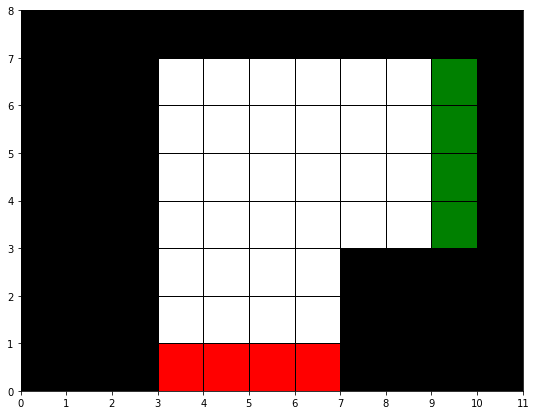

In [3]:
def plot_map():
    data = np.zeros((8, 11))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if (j, i) in track:
                data[i, j] = 1
            elif (j, i) in starting_line:
                data[i, j] = 2
            elif(j, i) in finishing_line:
                data[i, j] = 3
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.set_xticks(np.arange(0, 18, 1))
    ax.set_yticks(np.arange(0, 9, 1))
    cmap = colors.ListedColormap(["black", "white", "red", "green"])
    plt.pcolormesh(data, edgecolors="k", cmap=cmap)
plot_map()

In [4]:
def get_available_actions(state):
     available_actions = []
     x, y, v_x, v_y = state
     for v_x_inc in (-1, 0, 1):
          v_x_new = v_x + v_x_inc
          for v_y_inc in (-1, 0, 1):
               v_y_new = v_y + v_y_inc
               if not (v_x_new < 0 or v_y_new < 0 or v_x_new > 5 or v_y_new > 5 or
                    (v_x_new == 0 and v_y_new == 0)):
                    available_actions.append((v_x_inc, v_y_inc))
     return available_actions


In [5]:
state = (5, 0, 0, 0)
get_available_actions(state)

[(0, 1), (1, 0), (1, 1)]

In [6]:
def get_eps_greedy_probabilities(state, greedy_action, eps=0):
    probabilities = {}
    available_actions = get_available_actions(state)
    num_available_actions = len(available_actions)
    for action in available_actions:
        probabilities[action] = eps / num_available_actions
        if action == greedy_action:
            probabilities[action] += 1 - eps
    return probabilities

In [7]:
state = (3, 4, 3, 4)
get_eps_greedy_probabilities(state, random.choice(get_available_actions(state)), eps=0.1)

{(-1, -1): 0.011111111111111112,
 (-1, 0): 0.011111111111111112,
 (-1, 1): 0.011111111111111112,
 (0, -1): 0.011111111111111112,
 (0, 0): 0.011111111111111112,
 (0, 1): 0.9111111111111111,
 (1, -1): 0.011111111111111112,
 (1, 0): 0.011111111111111112,
 (1, 1): 0.011111111111111112}

In [8]:
def generate_start_state():
    start_x, start_y = random.choice(list(starting_line))
    return start_x, start_y, 0, 0

In [9]:
generate_start_state()

(5, 0, 0, 0)

In [10]:
def initialize_learning(eps):
    policy = {}
    Q = {}
    N = {}
    for x, y in starting_line.union(track):
        for v_x in range(6):
            for v_y in range(6):
                state = (x, y, v_x, v_y)
                available_actions = get_available_actions(state)
                policy[state] = get_eps_greedy_probabilities(state, random.choice(available_actions), eps)
                for a in available_actions:
                    Q[(state, a)] = 0
                    N[(state, a)] = 0
    return policy, Q, N

In [11]:
policy, Q, N = initialize_learning(0.1)
s = (5, 6, 5, 5)
a = random.choice(list(policy[s].keys()))
print("state s:", str(s), "- policy(s):", str(policy[s]))
print("state-action pair (s, a):", f"({s}, {a})", "- Q(s, a):", Q[(s, a)])
print("state-action pair (s, a):", f"({s}, {a})", "- N(s, a):", N[(s, a)])

state s: (5, 6, 5, 5) - policy(s): {(-1, -1): 0.025, (-1, 0): 0.925, (0, -1): 0.025, (0, 0): 0.025}
state-action pair (s, a): ((5, 6, 5, 5), (0, 0)) - Q(s, a): 0
state-action pair (s, a): ((5, 6, 5, 5), (0, 0)) - N(s, a): 0


In [12]:
def select_action_according_to_policy(policy, state):
    return random.choices(list(policy[state].keys()), list(policy[state].values()))[0]

In [13]:
state = (3, 4, 3, 4)
x = [select_action_according_to_policy(policy, state) for _ in range(100000)]
print(policy[state])
print(Counter(x).keys())
print(Counter(x).values())

{(-1, -1): 0.011111111111111112, (-1, 0): 0.011111111111111112, (-1, 1): 0.011111111111111112, (0, -1): 0.011111111111111112, (0, 0): 0.9111111111111111, (0, 1): 0.011111111111111112, (1, -1): 0.011111111111111112, (1, 0): 0.011111111111111112, (1, 1): 0.011111111111111112}
dict_keys([(0, 0), (0, -1), (1, 1), (1, 0), (-1, -1), (-1, 1), (-1, 0), (0, 1), (1, -1)])
dict_values([91158, 1086, 1055, 1109, 1122, 1118, 1109, 1151, 1092])


In [14]:
def generate_episode(policy, max_num_steps=1000000, noise=0):
    states = []
    actions = []
    rewards = []
    state = generate_start_state()
    for t in range(max_num_steps):
        states.append(state)
        x, y, v_x, v_y = state
        action = select_action_according_to_policy(policy, state)
        actions.append(action)
        if random.random() < noise:
            action = (0, 0)
        new_v_x = v_x + action[0]
        new_v_y = v_y + action[1]
        new_x = x + new_v_x
        new_y = y + new_v_y
        state = (new_x, new_y, new_v_x, new_v_y)
        if new_x >= 9 and new_y >= 3 and new_y <= 6:
            # Crossed finishing line
            rewards.append(0)
            break
        elif (new_x, new_y) not in starting_line.union(track):
            # Ran out of bounds
            state = generate_start_state()
        rewards.append(-1)
    return states, actions, rewards

In [15]:
states, actions, rewards = generate_episode(policy, max_num_steps=12)
print(states)
print(actions)
print(rewards)

[(4, 0, 0, 0), (5, 0, 1, 0), (6, 0, 0, 0), (6, 0, 0, 0), (4, 0, 0, 0), (5, 0, 1, 0), (5, 0, 0, 0), (6, 1, 1, 1), (5, 0, 0, 0), (6, 1, 1, 1), (6, 0, 0, 0), (6, 0, 0, 0)]
[(1, 0), (1, 1), (1, 0), (1, 0), (1, 0), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 0), (1, 0)]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [16]:
def plot_trajectory(states):
    plot_map()
    x = []
    y = []
    for i in range(len(states)):
        x.append(states[i][0] + 0.5)
        y.append(states[i][1] + 0.5)
    plt.plot(x, y, "-o")

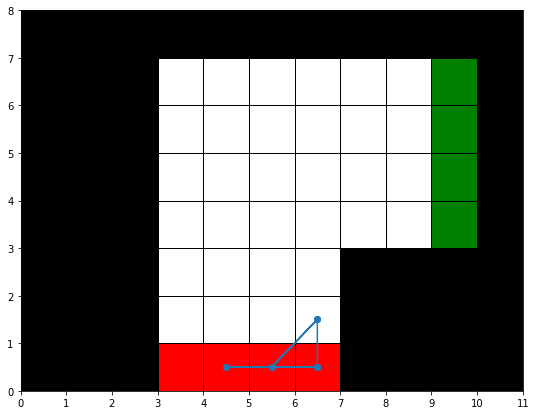

In [17]:
plot_trajectory(states)

In [18]:
def get_greedy_action(Q, state):
    max_val = -np.inf
    greedy_action = None
    for action in get_available_actions(state):
        if Q[(state, action)] > max_val:
            max_val = Q[(state, action)]
            greedy_action = action
    return greedy_action

In [19]:
# On-policy every visit MC control (eps-soft policies)
def learn_from_episode(policy, Q, N, states, actions, rewards, gamma=1, eps=0.1):
    G = 0
    for t in range(len(states) - 1, -1, -1):
        G = gamma * G + rewards[t]
        s = states[t]
        a = actions[t]
        N[(s, a)] += 1
        Q[(s, a)] += (G - Q[(s, a)]) / N[(s, a)]
        policy[s] = get_eps_greedy_probabilities(s, get_greedy_action(Q, s), eps)
    return policy, Q, N

In [20]:
policy, Q, N = learn_from_episode(policy, Q, N, states, actions, rewards)

In [21]:
Q[(states[0], actions[0])]

-10.0

In [22]:
# Learn from many episodes
num_episodes = 100000
policy, Q, N = initialize_learning(1)
for ep in range(num_episodes):
    states, actions, rewards = generate_episode(policy, noise=0.0) # TODO: Add noise
    eps = (num_episodes - ep) / (2 * num_episodes)
    policy, Q, N = learn_from_episode(policy, Q, N, states, actions, rewards, eps=eps)

In [23]:
len(N.values())

9072

In [24]:
np.sum(np.array(list(N.values())) != 0)

1138

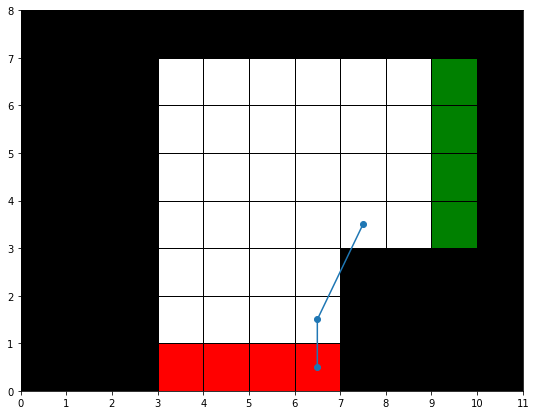

In [25]:
states, actions, rewards = generate_episode(policy)
plot_trajectory(states)

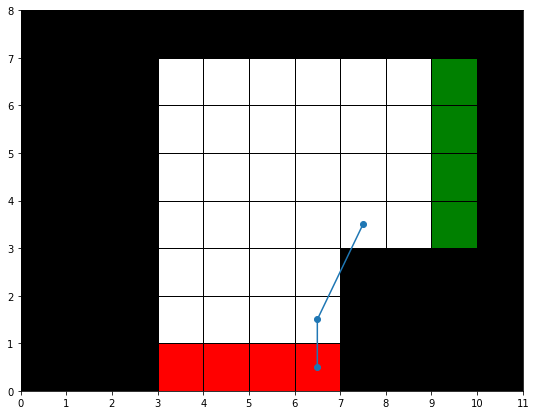

In [26]:
states, actions, rewards = generate_episode(policy)
plot_trajectory(states)

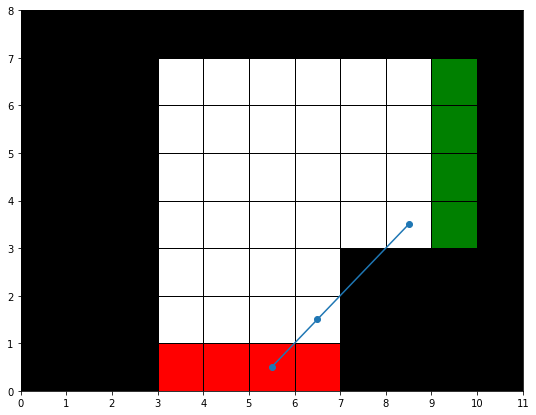

In [27]:
states, actions, rewards = generate_episode(policy)
plot_trajectory(states)

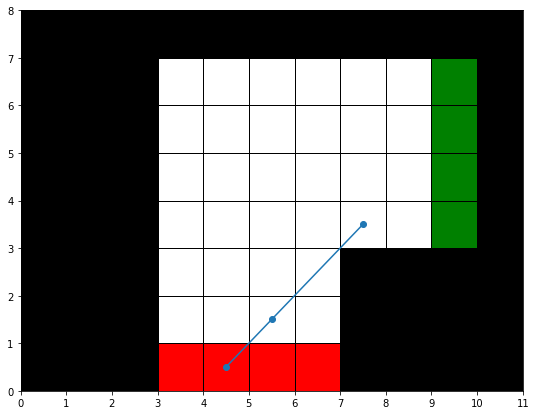

In [28]:
states, actions, rewards = generate_episode(policy)
plot_trajectory(states)